In [20]:
"""-
A test file for adding background noise to the audio clips.
"""

import os
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchaudio
import torch.nn.functional as F
import torchaudio.transforms as T


from IPython.display import Audio, display

In [21]:
def snr_noise(speech_dpath, noise_dpath, snr_db=10, sample_length=16000):
    """
    Add the SNR noise to a speech data.
    """

    # load the speech and nosie data
    waveform, speech_sampling_rate = torchaudio.load(speech_dpath)
    noise, noise_sampling_rate = torchaudio.load(noise_dpath)
    if waveform.shape[1] < sample_length:
        # padding if the audio length is smaller than samping length.
        waveform = F.pad(waveform, [0, sample_length - waveform.shape[1]])
    else:
        pass

    # process the speech audio data
    pad_length = int(waveform.shape[1] * 0.1)
    waveform = F.pad(waveform, [pad_length, pad_length])
    offset = torch.randint(0, waveform.shape[1] - sample_length + 1, size=(1,)).item()
    waveform = waveform.narrow(1, offset, sample_length)

    # process the noise data
    offset = torch.randint(0, noise.shape[1] - sample_length + 1, size=(1,)).item()
    noise = noise.narrow(1, offset, sample_length)

    # add the background noise by SNR
    speech_power = waveform.norm(p=2)
    noise_power = noise.norm(p=2)

    snr = math.exp(snr_db / 10)
    scale = snr * noise_power / speech_power
    noisy_speech = (scale * waveform + noise) / 2
    return noisy_speech

In [22]:
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [23]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

    
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)


Play the keyword speech


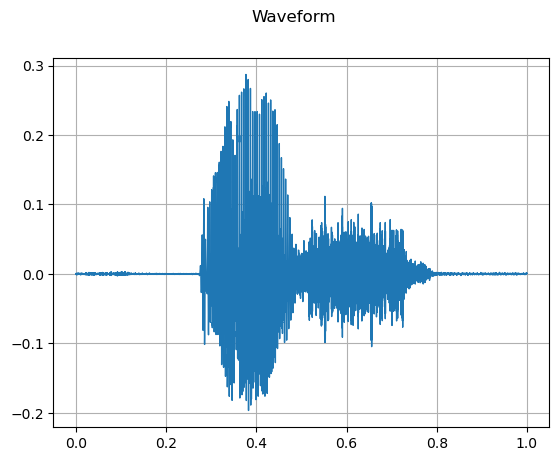

Play the processed noise


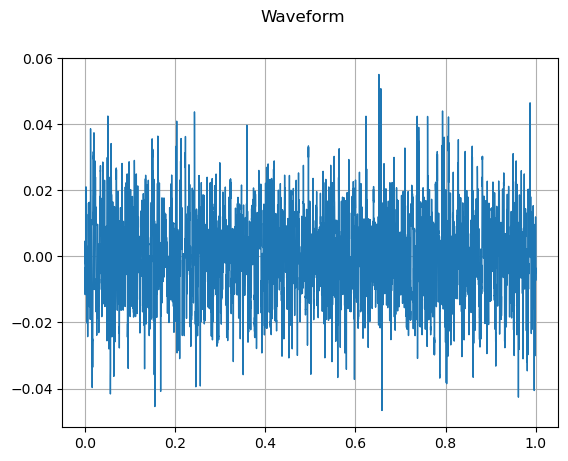

Play the noise keyword speech (SNR)


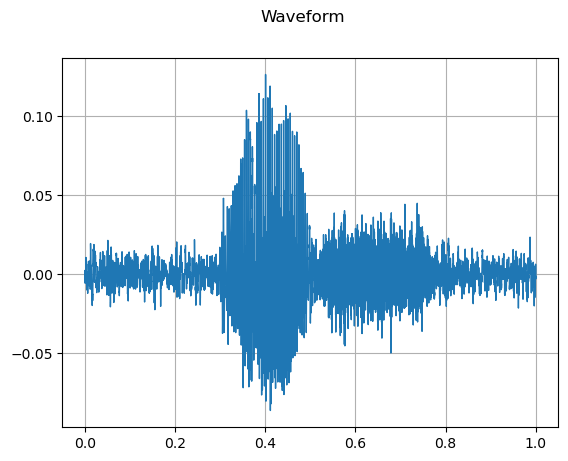

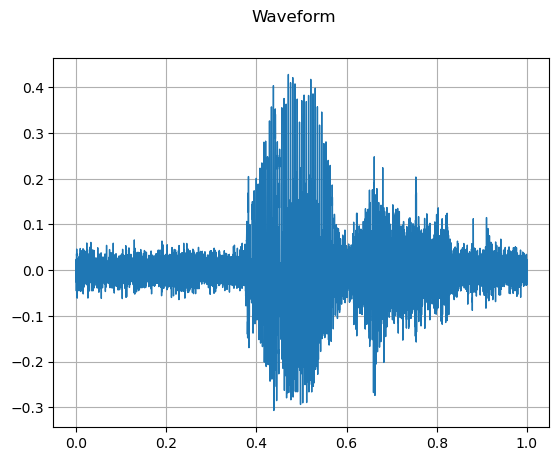

In [26]:
# load background data as learning noise.
noise_dataset = []
noise_path = os.path.join("../../dataset/data", "_background_noise_")
for root, _, filenames in sorted(os.walk(noise_path, followlinks=True)):
    for fn in sorted(filenames):
        name, ext = fn.split(".")
        if ext == "wav":
            noise_dataset.append(os.path.join(root, fn))

# load the speech and the noise audios.
noise, noise_sampling_rate = torchaudio.load(noise_dataset[0]) # use noise 0

# play the noise 
# print("Play the noise")
# play_audio(noise, noise_sampling_rate)
# plot_waveform(noise, speech_sampling_rate)

# setup the sampling length
sample_length = 16000

# load the keyword speech audio 
waveform, speech_sampling_rate = torchaudio.load('../../dataset/data/yes/0a7c2a8d_nohash_0.wav') # "yes"
if waveform.shape[1] < sample_length:
    # padding if the audio length is smaller than samping length.
    waveform = F.pad(waveform, [0, sample_length - waveform.shape[1]])
else:
    pass

# play the keyword speech  
print("Play the keyword speech")
play_audio(waveform, speech_sampling_rate)
plot_waveform(waveform, speech_sampling_rate)

# process the audio data
pad_length = int(waveform.shape[1] * 0.1)
waveform = F.pad(waveform, [pad_length, pad_length])
offset = torch.randint(0, waveform.shape[1] - sample_length + 1, size=(1,)).item()
waveform = waveform.narrow(1, offset, sample_length)

# print("Play the processed keyword speech")
# play_audio(waveform, speech_sampling_rate)
# plot_waveform(waveform, speech_sampling_rate)

# add the background noise to the keyword data
offset = torch.randint(0, noise.shape[1] - sample_length + 1, size=(1,)).item()
noise = noise.narrow(1, offset, sample_length)
# background_volume = torch.rand(size=(1,)).item()
# waveform.add_(noise.mul_(background_volume)).clamp(-1, 1)

# print("Play the noise keyword speech")
# play_audio(waveform, speech_sampling_rate)
# plot_waveform(waveform, speech_sampling_rate)

print("Play the processed noise")
play_audio(noise, noise_sampling_rate)
plot_waveform(noise, noise_sampling_rate)

# add the background noise by SNR
speech_power = waveform.norm(p=2)
noise_power = noise.norm(p=2)

snr_db = 10
snr = math.exp(snr_db / 10)
scale = snr * noise_power / speech_power
noisy_speech = (scale * waveform + noise) / 2

print("Play the noise keyword speech (SNR)")
play_audio(noisy_speech, speech_sampling_rate)
plot_waveform(noisy_speech, speech_sampling_rate)
# plot_waveform(noise, speech_sampling_rate)


print("===================================")
aud = snr_noise('../../dataset/data/yes/0a7c2a8d_nohash_0.wav', noise_dataset[0], snr_db=10)
play_audio(aud, speech_sampling_rate)
plot_waveform(aud, speech_sampling_rate)